# BloqadeNoisy tutorial
Stochastic wavefunction simulator written for Bloqade

In [12]:
using BloqadeNoisy #import BloqadeNoisy
using Bloqade
using Plots
pythonplot()
using Yao
using LaTeXStrings
using LinearAlgebra
using Kronecker

## Basic workflow

In [107]:
#pre-built noise model
noise_model = Aquila()

ErrorModel(BloqadeNoisy._aquila_confusion_mat, BloqadeNoisy._aquila_collapse_operators, BloqadeNoisy._aquila_coherent_noisy)

In [108]:
reg = zero_state(1)
h = rydberg_h([(0,0)], Ω = 15, Δ = 0)
save_times = LinRange(0, 10, 500) #choose the times at which to save the solution

ns = NoisySchrodingerProblem(reg, save_times, h, Aquila())
#Pretty printing!

NoisySchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 10.0)

  equation: 
    storage size: 40 bytes
    expression:
nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] 2π ⋅ 1.19 ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


collapse operators: 1
    algorithm: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))


In [109]:
sim = emulate(ns, 2000) #default output is the average probability amplitudes in the computational basis

500-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [0.9776103649113498, 0.02238963508865104]
 [0.912617776810278, 0.08738222318972193]
 [0.8107451155617799, 0.18925488443821997]
 [0.6814418102905208, 0.3185581897094794]
 [0.5369195164252726, 0.4630804835747272]
 [0.38952211384654295, 0.610477886153456]
 [0.2527900674734266, 0.7472099325265726]
 [0.13907059162412153, 0.860929408375878]
 [0.058213988489420616, 0.9417860115105788]
 ⋮
 [0.3363881671659259, 0.6636118328340744]
 [0.3428062946332013, 0.6571937053667987]
 [0.3633543399362451, 0.6366456600637547]
 [0.39561757280120163, 0.6043824271987981]
 [0.4375579222910933, 0.562442077708906]
 [0.48453028652435043, 0.5154697134756497]
 [0.5327245840077041, 0.46727541599229605]
 [0.5773728079156378, 0.4226271920843622]
 [0.6150972922693365, 0.38490270773066304]

In [110]:
end_state = last(sim)

2-element Vector{Float64}:
 0.6150972922693365
 0.38490270773066304

In [111]:
println(measure_noisy(noise_model, end_state))
#Make 10000 noisy measurements of the above state and average
measure_noisy(noise_model, end_state; nshots = 100)

DitStr{2, 1, Int64}[1 ₍₂₎]


100-element Vector{DitStr{2, 1, Int64}}:
 0 ₍₂₎
 1 ₍₂₎
 1 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎
 1 ₍₂₎
     ⋮
 1 ₍₂₎
 1 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎
 0 ₍₂₎
 0 ₍₂₎
 1 ₍₂₎

## Expectation values

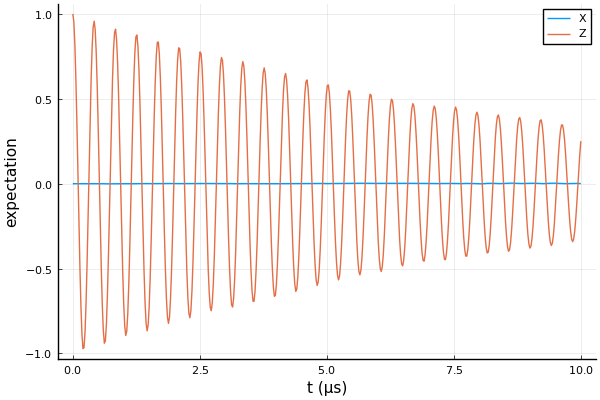

In [112]:
#Get expectation values
sim = emulate(ns, 1000, mat.([X,Z]))
plot(save_times, sim[1], label = "X", xlabel = "t (µs)", ylabel = "expectation")
plot!(save_times, sim[2], label = "Z")
current()

### Readout noise

0.98

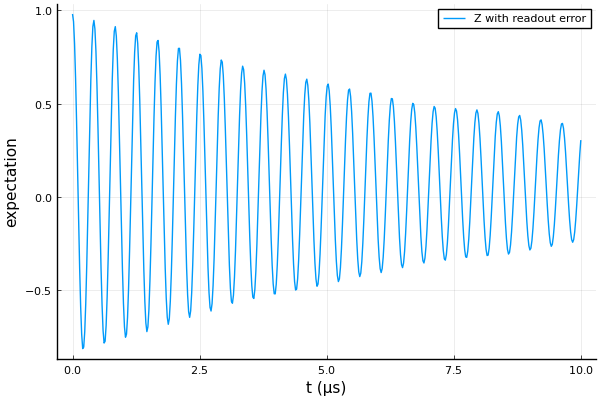

In [20]:
#For operators in the computational basis, readout noise can also be incorporated
sim = emulate(ns, 2000, [mat(Z)]; readout_error = true)
print(sim[1][1]) #.98 = .99 - .01 reflecting .01 probability of confusing ground with Rydberg
plot(save_times, sim[1], label = "Z with readout error", xlabel = "t (µs)", ylabel = "expectation")

### Estimating accuracy

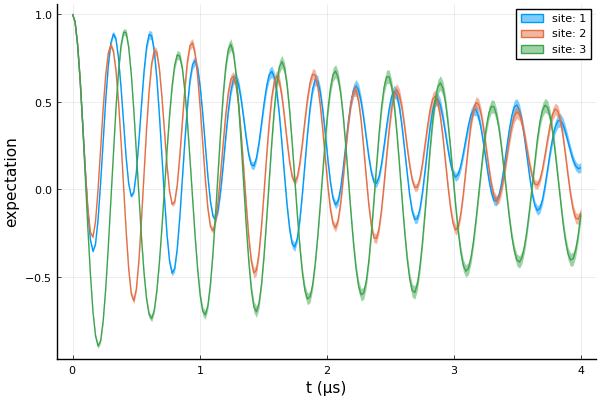

In [114]:
#Error estimation
#The error from a finite number of trajectories can also be estimated:
reg = zero_state(3)
h = rydberg_h([(0,0), (8,0), (18,0)], Ω = 15, Δ = 0)
save_times = LinRange(0, 4, 200) #choose the times at which to save the solution

ns = NoisySchrodingerProblem(reg, save_times, h, Aquila())
sim = emulate(ns, 500, [mat(put(3, i=>Z)) for i in 1:3]; report_error = true)
plot(xlabel = "t (µs)", ylabel = "expectation")
for i in 1:3
    plot!(save_times, sim.expectations[i], ribbon = sim.twosigma[i], label = "site: $i")
end
current()

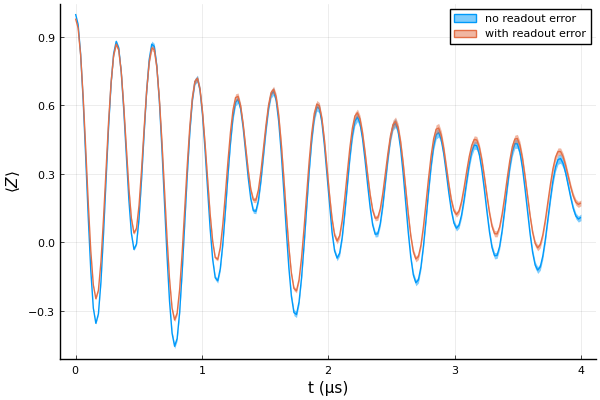

In [116]:
#add readout noise to an expectation value and estimate the error
sim = emulate(ns, 2000, [mat(put(3, 1=>Z))]; report_error = true)
sim_ro = emulate(ns, 2000, [mat(put(3, 1=>Z))]; readout_error = true, report_error = true)

plot(save_times, sim.expectations[1], ribbon = sim.twosigma[1], label = "no readout error", xlabel = "t (µs)", ylabel = L"\langle Z \rangle")
plot!(save_times, sim_ro.expectations[1], ribbon = sim_ro.propagated_error[1], label = "with readout error") #Gaussian error propagation

## Eperimental shots
The number of shots can be restricted without changing the number of trajectories to simulate an experimental setting.

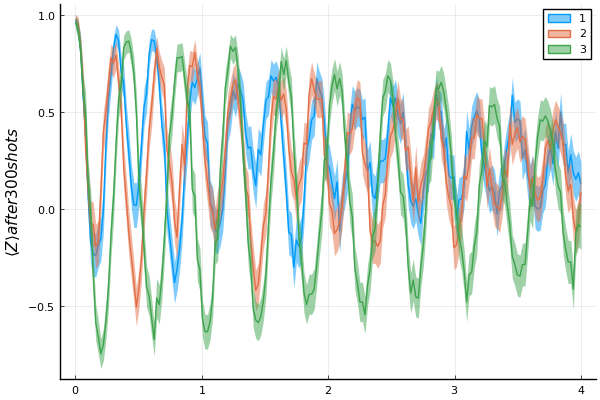

In [117]:
#For observables that are diagonal in the computational basis, the value after a finite number of experimental
#shots can also be simulated with error

sim = emulate(ns, 500, [mat(put(3, i=>Z)) for i in 1:3]; readout_error = true, report_error = true, shots = 300)
plot(xlable = "t (µs)", ylabel = L"\langle Z \rangle after 300 shots")
for i in 1:3
    plot!(save_times, sim.expectations[i], ribbon = sim.shot_error[i], label = "$i")
end
current()

In [48]:
#If desired, noisy experimental shots can be simulated directly:
sim = emulate(ns, 500)
t = save_times[100] #arbitrary
println(t)
measure_noisy(Aquila(), sim[100]; nshots = 10)

1.9899497487437185


10-element Vector{DitStr{2, 3, Int64}}:
 100 ₍₂₎
 100 ₍₂₎
 000 ₍₂₎
 010 ₍₂₎
 000 ₍₂₎
 000 ₍₂₎
 011 ₍₂₎
 011 ₍₂₎
 001 ₍₂₎
 011 ₍₂₎

## Code injection

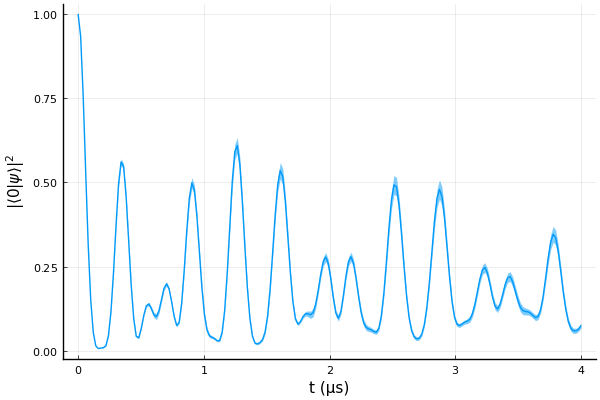

In [118]:
#For custom output, emulate can be called with an output function that transforms the (normalized) solution
sim = emulate(ns, 500, sol -> [abs(u[1])^2 for u in sol])
values = simulation_series_mean(sim) #convenience method for taking the mean over the trajectories
error = simulation_series_err(sim) #estimate the error based on the sampling variance
plot(save_times, values, ribbon = error, xlabel = "t (µs)", ylabel = L"|\langle 0 |ψ\rangle|^2", label = "")

In [5]:
#If more custom control is desired, then an EnsembleProblem can be created directly with the following:
using DifferentialEquations
randomize(ns) #samples a new trajectory with a modified Hamiltonian and different initial conditions
ep = EnsembleProblem(ns, prob_func = (prob, i, repeat)->randomize(ns))
solve(ep, trajectories = 10)

EnsembleSolution Solution of length 10 with uType:
ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, NoisySchrodingerProblem{ArrayReg{2, ComplexF64, Matrix{ComplexF64}}, ODEFunction{true, SciMLBase.FullSpecialize, NoisySchrodingerEquation{SparseMatrixCSC{ComplexF64, Int64}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{ComplexF64}, Tuple{Float64, Float64}, DP8{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Base.Pairs{Symbol, Any, NTuple{6, Symbol}, NamedTuple{(:save_everystep, :dense, :reltol, :abstol, :saveat, :callback), Tuple{Bool, Bool, Float64, Float64, LinRange{Float64, Int64}, ContinuousCallback{typeof(BloqadeNoisy.collapse_condition), BloqadeNoisy.var"#22#24"{Vector{SparseMatrixCSC{Compl

In [8]:
# Custom noise models
# A custom incoherent noise model can be implemented by specifying the collapse operators
rate = 1/10
reg = zero_state(1)
c_ops = [sqrt(rate)*mat((X+im*Y)/2)] #this noise model will not have any coherent error
h = rydberg_h([(0,0)], Ω = 15)
ns = NoisySchrodingerProblem(reg, save_times, h, c_ops)

NoisySchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 4.0)

  equation: 
    storage size: 40 bytes
    expression:
nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
└─ [+] 2π ⋅ 1.19 ⋅ ∑ σ^x_i


collapse operators: 1
    algorithm: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))


In [119]:
#A custom coherent noise mode
#Cutom coherent and readout noise models can be implemented using the following interface
trivial_error_model = ErrorModel(
    n -> Matrix(I, n, n),
    n -> [],
    h -> (() -> h)
)

ErrorModel(var"#269#273"(), var"#270#274"(), var"#271#275"())

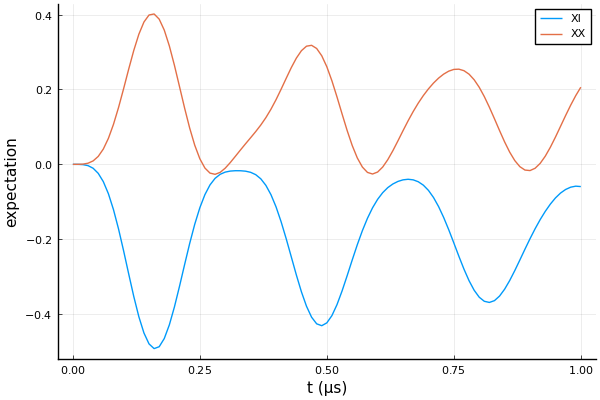

In [106]:
#A more complicated error model would look like the following:
confusion_matrix(n) = kronecker([[[.9 .1];[.1 .9]] for i in 1:n]...)
bitflip_model(n) = [SparseMatrixCSC(sqrt(1/10)*mat(put(n, i=>X))) for i in 1:n]
coherent_noise(h) = () -> ((atoms,ϕ,Ω,Δ)=get_rydberg_params(h); rydberg_h(atoms; Ω = Ω*(1+.08*randn()), Δ = Δ, ϕ = ϕ))

better_error_model = ErrorModel(
    confusion_matrix,
    bitflip_model,
    coherent_noise
)

ns = NoisySchrodingerProblem(zero_state(2), 0:1f-2:1, rydberg_h([(0,),(8)]; Ω = 15), better_error_model)
sim = emulate(ns, 1000, [mat(put(2, 1=>X)), mat(kron(X, X))])
plot(0:1f-2:1, sim[1], label = "XI", xlabel = "t (µs)", ylabel = "expectation")
plot!(0:1f-2:1, sim[2], label = "XX")